In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/top_influential_full_data.csv')
df.head()

/var/folders/ty/kkyy7c9s4059czrtyxg_0mz40000gn/T/ipykernel_58202/77531029.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/jacksonsorenson/Documents/Computational Media Lab/Weed Study/CSV for mass database organization/R:Dabs/top_influential_full_data.csv')


,node_type,depth,id,parent_id,post_id,created_utc,author,score,body_text,parent_body_text,distinguished,num_comments,media,quarter,Epoch
0,comment,1,ce3prbv,1t2ljg,NaN,2013-12-17 07:09:59,badf1nger,2,Have an upvote.,Fuckin' dabs\n\nSo I live in the Northwest and...,NaN,NaN,NaN,2013Q4,E0_Seed
1,comment,1,ce6o8s3,1tcfmq,NaN,2013-12-20 23:07:43,badf1nger,1,Nice! Have you looked into getting an E-dabbe...,My traveling dab setup\n\nnan,NaN,NaN,NaN,2013Q4,E0_Seed
2,comment,1,cfbveoc,1xjdrt,NaN,2014-02-10 18:59:10,badf1nger,1,I see someone else dabs and longboards. Join...,New oil setup!\n\nnan,NaN,NaN,NaN,2014Q1,E0_Seed
3,post,0,1xobfa,NaN,1xobfa,2014-02-12 03:08:30,badf1nger,5,Dab shelf\n\nnan,NaN,NaN,0.0,NaN,2014Q1,E0_Seed
4,comment,1,cfvcjhe,1zn8u6,NaN,2014-03-05 22:44:32,guccikins,1,I was going to try this. There is a kid on her...,Will this work for dabbing? I currently use an...,NaN,NaN,NaN,2014Q1,E0_Seed


In [17]:
sample_df = (
    df[df['body_text'].notna()]
    .groupby("Epoch", group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 7000), random_state=42))
    .reset_index(drop=True)
)


/var/folders/ty/kkyy7c9s4059czrtyxg_0mz40000gn/T/ipykernel_58202/1948804952.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [20]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

stop_words = list(ENGLISH_STOP_WORDS)

vectorizer_model = CountVectorizer(stop_words=stop_words)
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine")
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=10, prediction_data=True)


In [21]:
documents = sample_df["body_text"].astype(str).tolist()

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(documents)


2025-06-03 20:06:37,868 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 672/672 [00:27<00:00, 24.65it/s]
2025-06-03 20:07:06,420 - BERTopic - Embedding - Completed ✓
2025-06-03 20:07:06,421 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-03 20:07:18,282 - BERTopic - Dimensionality - Completed ✓
2025-06-03 20:07:18,283 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

In [22]:
reduced_model = topic_model.reduce_topics(documents, nr_topics=15)
topics_reduced, probs_reduced = reduced_model.transform(documents)

# Use reduced model and topic output
topic_model = reduced_model
sample_df["topic"] = topics_reduced


2025-06-03 20:07:57,356 - BERTopic - Topic reduction - Reducing number of topics
2025-06-03 20:07:57,405 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-03 20:07:57,667 - BERTopic - Representation - Completed ✓
2025-06-03 20:07:57,669 - BERTopic - Topic reduction - Reduced number of topics from 112 to 15
Batches: 100%|██████████| 672/672 [00:26<00:00, 25.07it/s]
2025-06-03 20:08:24,840 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-06-03 20:08:24,909 - BERTopic - Dimensionality - Completed ✓
2025-06-03 20:08:24,909 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-06-03 20:08:25,279 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-06-03 20:08:31,230 - BERTopic - Probabilities - Completed ✓
2025-06-03 20:08:31,230 - BERTopic - Cluster - Completed ✓


In [23]:
from collections import defaultdict

topic_keywords = defaultdict(list)
print("\n—— Reduced keywords for labeling ——\n")

for topic_id in topic_model.get_topic_info()["Topic"].tolist():
    if topic_id == -1:
        continue
    words = [word for word, _ in topic_model.get_topic(topic_id)[:5]]
    topic_keywords[topic_id] = words
    print(f"Topic {topic_id}: {', '.join(words)}")



—— Reduced keywords for labeling ——

Topic 0: thc, like, wax, just, silicone
Topic 1: nan, dab, dabs, dabbing, smoke
Topic 2: gram, im, state, just, like
Topic 3: lol, people, just, im, post
Topic 4: glass, quartz, china, diamonds, nail
Topic 5: thank, cheers, thanks, hope, appreciate
Topic 6: rig, puffco, enail, rigs, slurper
Topic 7: banger, temp, heat, cold, gun
Topic 8: torch, butane, propane, blazer, flame
Topic 9: reclaim, cap, caps, recycler, carb
Topic 10: rosin, crc, hash, bho, like
Topic 11: mids, like, closer, 600, 550
Topic 12: plug, plugs, reliable, need, patients
Topic 13: days, weeks, month, months, year


In [24]:
label_map = {
    0: "Silicone Accessories & THC Use",              # thc, wax, silicone
    1: "General Dabbing Discussion",                  # dab, dabbing, smoke
    2: "Basic Posting / State Mentions",              # gram, state, like
    3: "Casual / Social Talk",                        # lol, post, people
    4: "Glass & Nail Equipment",                      # quartz, diamonds, nail
    5: "Gratitude / Positive Tone",                   # thank, cheers, appreciate
    6: "Devices: Puffco, Rigs, Slurpers",             # rig, puffco, slurper
    7: "Temperature Tools & Setup",                   # banger, heat, temp
    8: "Torch Use & Safety",                          # butane, torch, flame
    9: "Reclaim & Recycler Gear",                     # reclaim, caps, recycler
    10: "Rosin, CRC, Hash Methods",                   # rosin, bho, crc
    11: "Potency / Strength Comparison",              # mids, closer, 600
    12: "Plugs & Market Supply",                      # plug, patients, reliable
    13: "Long-Term Use / Time References",            # months, years, weeks
    -1: "Other"                                       # catch-all outliers
}


In [29]:
sample_df['topic_label'].value_counts()


topic_label
Other                              8459
Silicone Accessories & THC Use     2691
General Dabbing Discussion         1758
Basic Posting / State Mentions     1538
Casual / Social Talk               1533
Glass & Nail Equipment             1251
Gratitude / Positive Tone          1097
Devices: Puffco, Rigs, Slurpers    1063
Temperature Tools & Setup           657
Torch Use & Safety                  519
Reclaim & Recycler Gear             356
Rosin, CRC, Hash Methods            355
Potency / Strength Comparison       149
Plugs & Market Supply                38
Long-Term Use / Time References      30
Name: count, dtype: int64

In [26]:
sample_df["topic_label"] = sample_df["topic"].apply(lambda x: label_map.get(x, "Other"))


In [27]:
for label in set(label_map.values()):
    col_name = label.replace(" ", "_").replace("/", "_").replace("&", "and")
    sample_df[col_name] = (sample_df["topic_label"] == label).astype(int)


In [28]:
df['Epoch'].value_counts()


Epoch
E2_PandemicBoom    27728
E3_PostPeak        26021
E1_Takeoff         20040
E0_Seed              494
Name: count, dtype: int64

In [30]:
# Custom sample size per epoch
sample_sizes = {
    "E0_Seed": 494,             # take all
    "E1_Takeoff": 3000,
    "E2_PandemicBoom": 3000,
    "E3_PostPeak": 3000
}

# Filter and sample
sample_df = pd.concat([
    df[(df["Epoch"] == epoch) & df["body_text"].notna()]
      .sample(n=min(len(df[df["Epoch"] == epoch]), n), random_state=42)
    for epoch, n in sample_sizes.items()
]).reset_index(drop=True)


In [31]:
documents = sample_df["body_text"].astype(str).tolist()


In [32]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

stop_words = list(ENGLISH_STOP_WORDS)
vectorizer_model = CountVectorizer(stop_words=stop_words)
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine")
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=10, prediction_data=True)


In [33]:
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(documents)


2025-06-03 20:17:04,360 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 297/297 [00:12<00:00, 23.33it/s]
2025-06-03 20:17:18,560 - BERTopic - Embedding - Completed ✓
2025-06-03 20:17:18,563 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-03 20:17:29,568 - BERTopic - Dimensionality - Completed ✓
2025-06-03 20:17:29,571 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-03 20:17:30,488 - BERTopic - Cluster - Completed ✓
2025-06-03 20:17:30,501 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-03 20:17:30,619 - BERTopic - Representation - Completed ✓


In [34]:
reduced_model = topic_model.reduce_topics(documents, nr_topics=15)
topics_reduced, probs_reduced = reduced_model.transform(documents)

# Replace model and attach topics
topic_model = reduced_model
sample_df["topic"] = topics_reduced


2025-06-03 20:17:50,636 - BERTopic - Topic reduction - Reducing number of topics
2025-06-03 20:17:50,656 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-03 20:17:50,760 - BERTopic - Representation - Completed ✓
2025-06-03 20:17:50,762 - BERTopic - Topic reduction - Reduced number of topics from 60 to 15
Batches: 100%|██████████| 297/297 [00:12<00:00, 24.01it/s]
2025-06-03 20:18:04,601 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-06-03 20:18:04,640 - BERTopic - Dimensionality - Completed ✓
2025-06-03 20:18:04,641 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-06-03 20:18:04,792 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-06-03 20:18:05,758 - BERTopic - Probabilities - Completed ✓
2025-06-03 20:18:05,758 - BERTopic - Cluster - Completed ✓


In [35]:
label_map = {
    0: "Silicone Accessories & THC Use",
    1: "General Dabbing Discussion",
    2: "Basic Posting / State Mentions",
    3: "Casual / Social Talk",
    4: "Glass & Nail Equipment",
    5: "Gratitude / Positive Tone",
    6: "Devices: Puffco, Rigs, Slurpers",
    7: "Temperature Tools & Setup",
    8: "Torch Use & Safety",
    9: "Reclaim & Recycler Gear",
    10: "Rosin, CRC, Hash Methods",
    11: "Potency / Strength Comparison",
    12: "Plugs & Market Supply",
    13: "Long-Term Use / Time References",
    -1: "Other"
}

sample_df["topic_label"] = sample_df["topic"].apply(lambda x: label_map.get(x, "Other"))


In [39]:
# Set desired Epoch order and topic order
epoch_order = ["E0_Seed", "E1_Takeoff", "E2_PandemicBoom", "E3_PostPeak"]

topic_order = [
    "General Dabbing Discussion",
    "Silicone Accessories & THC Use",
    "Torch Use & Safety",
    "Temperature Tools & Setup",
    "Devices: Puffco, Rigs, Slurpers",
    "Glass & Nail Equipment",
    "Rosin, CRC, Hash Methods",
    "Potency / Strength Comparison",
    "Plugs & Market Supply",
    "Reclaim & Recycler Gear",
    "Gratitude / Positive Tone",
    "Basic Posting / State Mentions",
    "Casual / Social Talk",
    "Long-Term Use / Time References",
    "Other"
]

# Compute topic counts per epoch
topic_epoch_counts = (
    sample_df.groupby(["Epoch", "topic_label"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=epoch_order, columns=topic_order)
)

topic_epoch_counts


topic_label,General Dabbing Discussion,Silicone Accessories & THC Use,Torch Use & Safety,Temperature Tools & Setup,"Devices: Puffco, Rigs, Slurpers",Glass & Nail Equipment,"Rosin, CRC, Hash Methods",Potency / Strength Comparison,Plugs & Market Supply,Reclaim & Recycler Gear,Gratitude / Positive Tone,Basic Posting / State Mentions,Casual / Social Talk,Long-Term Use / Time References,Other
Epoch,,,,,,,,,,,,,,,
E0_Seed,58,62,0,7,22,21,4,0,0,22,19,54,18,4,203
E1_Takeoff,278,429,15,101,136,134,65,43,11,66,87,136,211,16,1272
E2_PandemicBoom,218,335,66,79,156,160,26,24,22,48,161,205,172,11,1317
E3_PostPeak,225,367,100,55,108,146,31,39,14,32,178,219,144,9,1333


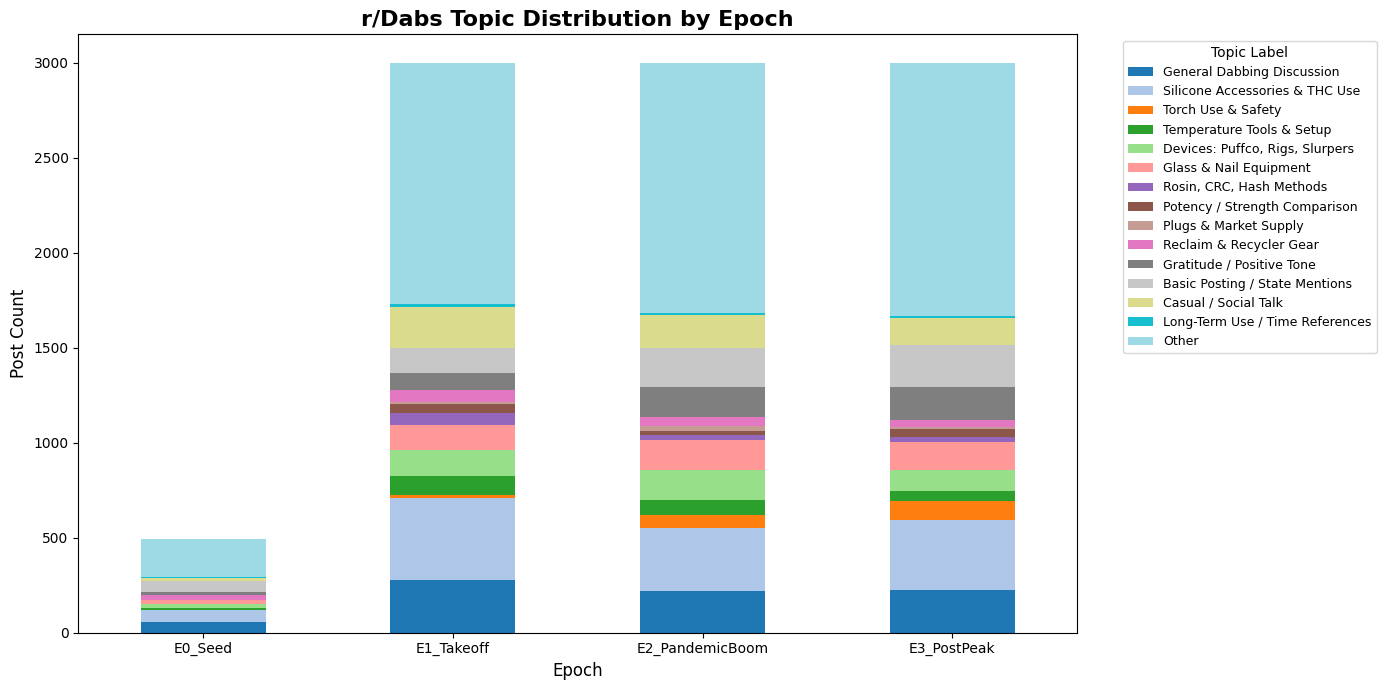

In [40]:
import matplotlib.pyplot as plt

# Set desired Epoch order
epoch_order = ["E0_Seed", "E1_Takeoff", "E2_PandemicBoom", "E3_PostPeak"]
topic_epoch_counts = topic_epoch_counts.loc[epoch_order]

# Set custom topic label order for better storytelling
topic_order = [
    "General Dabbing Discussion",
    "Silicone Accessories & THC Use",
    "Torch Use & Safety",
    "Temperature Tools & Setup",
    "Devices: Puffco, Rigs, Slurpers",
    "Glass & Nail Equipment",
    "Rosin, CRC, Hash Methods",
    "Potency / Strength Comparison",
    "Plugs & Market Supply",
    "Reclaim & Recycler Gear",
    "Gratitude / Positive Tone",
    "Basic Posting / State Mentions",
    "Casual / Social Talk",
    "Long-Term Use / Time References",
    "Other"
]

# Reorder columns
topic_epoch_counts = topic_epoch_counts[topic_order]

# Plot with improved aesthetics
fig, ax = plt.subplots(figsize=(14, 7))
topic_epoch_counts.plot(kind="bar", stacked=True, ax=ax, colormap="tab20")

ax.set_title("r/Dabs Topic Distribution by Epoch", fontsize=16, weight='bold')
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Post Count", fontsize=12)
ax.legend(title="Topic Label", bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=9)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
